In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_feather('data_RL18.feather')
df.station = pd.to_numeric(df.station, downcast='integer')

In [3]:
stations = df.groupby(by='station')[['lat','lon','alt','orog']].first().reset_index()
stations.station = pd.to_numeric(stations.station, downcast='integer')

In [4]:
import geopy.distance

def dist_km(lat1, lon1, lat2, lon2):
    """Returns distance bewtween two stations in km using the the WGS-84 ellipsoid.

    Args:
        lat1 (float): latitude of first station
        lat2 (float): latitude of second station
        lon1 (float): longitude of first station
        lon2 (float): longitude of second station

    Returns:
        float: distance in km
    """
    return geopy.distance.geodesic((lat1, lon1), (lat2, lon2)).km

In [5]:
# create a copy of the dataframe with only lat and lon columns
import seaborn as sns
coords_df = stations[['lat', 'lon']].copy()

# create numpy arrays for latitudes and longitudes
latitudes = np.array(coords_df['lat'])
longitudes = np.array(coords_df['lon'])

# create a meshgrid of latitudes and longitudes
lat_mesh, lon_mesh = np.meshgrid(latitudes, longitudes)

# calculate distance matrix using vectorized distance function
distance_matrix = np.vectorize(dist_km)(lat_mesh, lon_mesh, lat_mesh.T, lon_mesh.T)

# convert distance matrix to pandas dataframe and set column and row names
distance_matrix_df = pd.DataFrame(distance_matrix, index=stations.station, columns=stations.station)

In [50]:
# find 10 closest stations to each station
number_of_connections = 5
closest_stations = np.argsort(distance_matrix, axis=1)[:,:number_of_connections+1]

## 🕸️ Graph construction

In [51]:
import networkx as nx

g = nx.Graph()

# Add all Stations to the graph as node
stations.apply(lambda x: g.add_node(int(x.station), lon=x.lon, lat=x.lat, alt=x.alt, orog=x.orog), axis=1)

def add_n_edges(x:np.ndarray, n:int):
    for i in range(n):
        g.add_edge(x[0], x[i+1])
    return x


np.apply_along_axis(add_n_edges, axis=1, arr=closest_stations, n=number_of_connections)

array([[  1, 524, 250, 143, 253, 166],
       [  2, 521, 266, 472,  70, 206],
       [  3, 246, 357, 523, 500, 109],
       ...,
       [533,  27, 370, 208, 435, 428],
       [534, 169, 478, 170, 269, 151],
       [535, 442, 242,  72, 353, 532]])

## 📊 Plots

In [52]:
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
%matplotlib inline

plt.style.use("default")

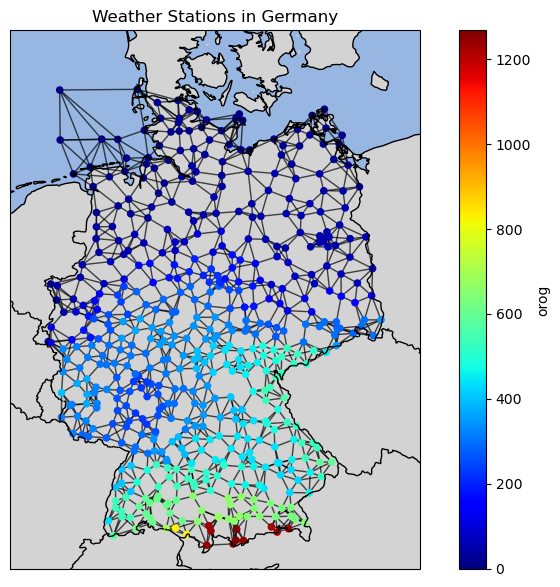

In [55]:
pos = {key+1:val for key, val in enumerate(list(stations[['lon','lat']].itertuples(index=False, name=None)))}

proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(1, 1, 1, projection=proj)

ax.coastlines()
ax.set_extent([5, 16, 47, 56], crs=proj)
ax.add_feature(cfeature.LAND, color="lightgrey")
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.OCEAN)


nx.draw_networkx(g, pos=pos, node_size=0, ax=ax, with_labels=False, alpha=0.7)

stations.plot(x="lon", y="lat", kind="scatter", c="orog", colormap="jet", title=f"Weather Stations in Germany", ax=ax)

# Fix the aspect ratio of the map
lat_center = (ax.get_extent()[2] + ax.get_extent()[3]) / 2
ax.set_aspect(1 / np.cos(np.radians(lat_center)))